In [1]:
import math
import os
import random
import warnings

import dill
import imageio
import gensim
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13.0, 13.0)

warnings.filterwarnings('ignore')

Using Theano backend.


In [2]:
# Loading patient2vec model
PATIENT2VEC_MODEL_DIR = "../patient2vec/models_improved/"
PATIENT2VEC_MODEL = "patient2vec_pvdbow_hs_win-30_emb-100.gen"
patient2vec = gensim.models.Doc2Vec.load(os.path.join(PATIENT2VEC_MODEL_DIR, PATIENT2VEC_MODEL))

# Loading Diabetes patients
all_patients = pd.read_csv('../diabetes/data/intermediate/patient_list_split.csv')
metform_indexes = np.where(all_patients["OUTCOME"].values == 1) # patients in metformin group
control_indexes = np.where(all_patients["OUTCOME"].values == 0) # patients in control group

# Metformin cohort and control

In [3]:
# Getting vectors for patients
p2v_vectors = np.array([patient2vec.docvecs[str(ptid)] for ptid in all_patients["IND_SEQ"]])

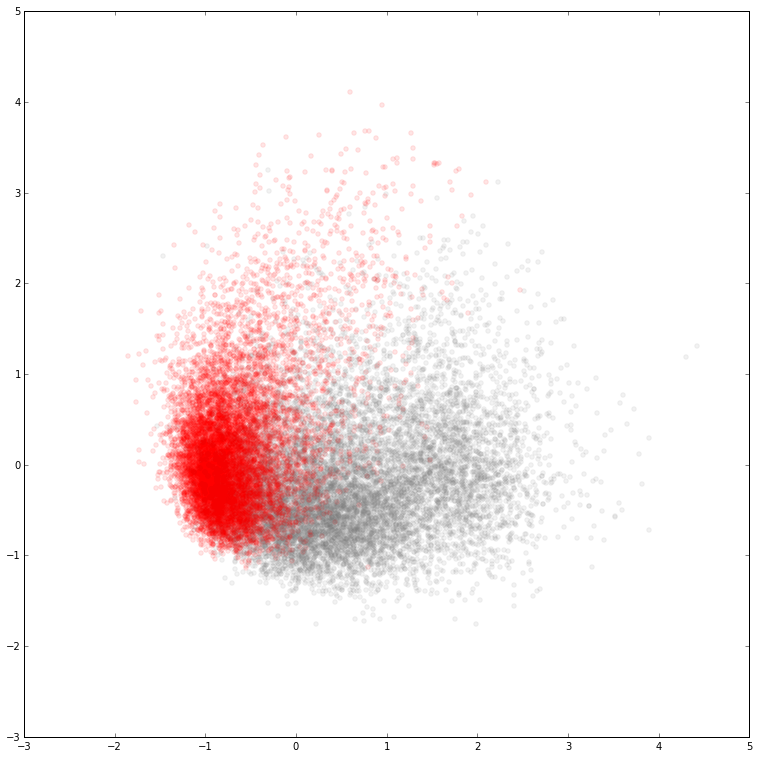

In [4]:
pca_1 = PCA(n_components=2, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=1)

pca_1_y = pca_1.fit_transform(p2v_vectors)
plt.scatter(pca_1_y[control_indexes][:,0], pca_1_y[control_indexes][:,1], color='grey', alpha=0.1)
plt.scatter(pca_1_y[metform_indexes][:,0], pca_1_y[metform_indexes][:,1], color='red', alpha=0.1)
plt.show()

# Metformin patients, control and 100,000 random patients

In [5]:
random.seed(1)

all_p2v_patients = list(patient2vec.docvecs.doctags.keys())
random_patients = random.sample(all_p2v_patients, 100000)

p2v_vectors = p2v_vectors.tolist()

for p in random_patients:
    v = patient2vec.docvecs[str(p)]
    p2v_vectors.append(v)

p2v_vectors_np = np.array(p2v_vectors)

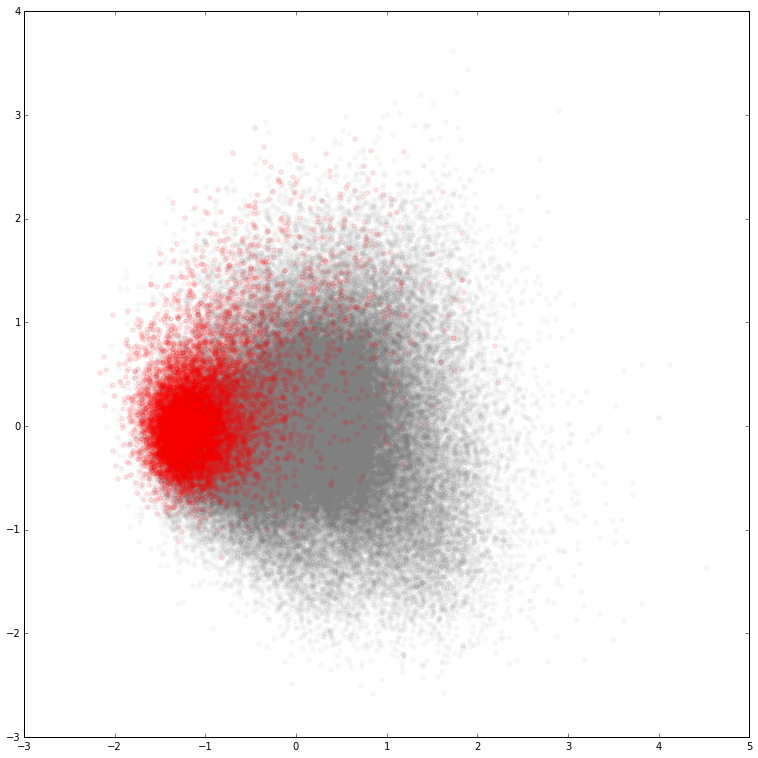

In [6]:
pca_2 = PCA(n_components=2, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=1)

pca_2_y = pca_2.fit_transform(p2v_vectors_np)
other_indexes = list(range(0, len(pca_2_y)))
for v in (metform_indexes[0].tolist()+control_indexes[0].tolist()):
    other_indexes.remove(v)
plt.scatter(pca_2_y[other_indexes][:,0], pca_2_y[other_indexes][:,1], color='grey', alpha=0.05)
plt.scatter(pca_2_y[control_indexes][:,0], pca_2_y[control_indexes][:,1], color='grey', alpha=0.05)
plt.scatter(pca_2_y[metform_indexes][:,0], pca_2_y[metform_indexes][:,1], color='red', alpha=0.1)
plt.show()

# Progress animations

In [7]:
# select icd_codes.ind_seq, icd_codes.entry_date, icd_codes.code, icd_desc.code_desc from icd_codes
# join icd_desc on icd_desc.code = icd_codes.code
# where icd_codes.ind_seq in
# (
#     select ind_seq from
#     (
#         select ind_seq, count(*), months_between(max(entry_date), min(entry_date)) from icd_codes where ind_seq in (select ind_seq from p2v_patients_outcome where outcome = 1) group by ind_seq order by months_between desc limit 15
#     ) as foo
# ) 
# order by ind_seq, entry_date


# (
#     select icd_codes.ind_seq, to_char(icd_codes.entry_date, 'YYYY-MM-DD') as entry_date, icd_codes.code, icd_codes.parent, icd_desc.code_desc, 'icd' as type from icd_codes
#     join icd_desc on icd_desc.code = icd_codes.code
#     where icd_codes.ind_seq in (86592, 69648, 473464, 296798, 414027, 44896, 611947, 54108, 338594, 447401, 23839, 76115, 329119, 59848, 510077)
# )
# UNION
# (
#     select ind_seq, to_char(entry_date, 'YYYY-MM-DD') as entry_date, generic_name as code, '0' as parent, generic_name as code_desc, 'med' as type from medex
#     where ind_seq in (86592, 69648, 473464, 296798, 414027, 44896, 611947, 54108, 338594, 447401, 23839, 76115, 329119, 59848, 510077)
#     AND drug_strength <> '' AND drug_strength IS NOT NULL AND route <> ''
#      AND route IS NOT NULL AND drug_freq <> '' AND drug_freq IS NOT NULL
#      AND generic_name IS NOT NULL AND generic_name <> ''
# )
# UNION
# (
#     select ind_seq, to_char(entry_date, 'YYYY-MM-DD') as entry_date, test_sname as code, '0' as parent, test_sname as code_desc, 'lab' as type from labs_num
#     where ind_seq in (86592, 69648, 473464, 296798, 414027, 44896, 611947, 54108, 338594, 447401, 23839, 76115, 329119, 59848, 510077)
# )
# order by ind_seq, entry_date

In [8]:
patients_histories = pd.read_csv('data/selected_diabetes_patients_history.csv')

def get_year_quarter(row):
    date = row['ENTRY_DATE']
    year, month, _ = date.split('-')
    return "{}-{}".format(year, math.ceil(int(month)/3))
    
patients_histories['YEAR-QUARTER'] = patients_histories.apply(lambda row: get_year_quarter(row), axis=1)
patient_groups = patients_histories.groupby(by='IND_SEQ')

In [9]:
patient_vector_histories = {}

for patient, history in patient_groups:   
    patient_vector_histories[patient] = {}
    patient_vector_histories[patient]['history'] = {}
    patient_vector_histories[patient]['full_df'] = history
    patient_vector_histories[patient]['first_diabetes'] = None 
    
    quarters = history.groupby(by='YEAR-QUARTER')
    combined_history = []

    for quarter, quarter_history in quarters:
        combined_history += quarter_history['CODE'].values.tolist()
        vector = patient2vec.infer_vector(combined_history)

        patient_vector_histories[patient]['history'][quarter] = {}  
        patient_vector_histories[patient]['history'][quarter]['vector'] = vector
        patient_vector_histories[patient]['history'][quarter]['data_frame'] = quarter_history
        
        if (not patient_vector_histories[patient]['first_diabetes']) and ('250' in quarter_history['PARENT'].values.tolist()):
            patient_vector_histories[patient]['first_diabetes'] = quarter
        
    
dill.dump(patient_vector_histories, open('data/diabetes_histories.dill', 'wb'))

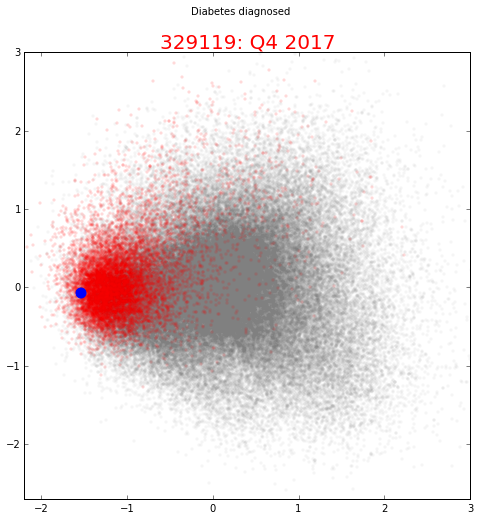

In [10]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

def format_date(date_string):
    year, quarter = date_string.split('-')
    return 'Q{} {}'.format(quarter, year)
    

def plot_quarter(patient, quarter, patient_point, after_diabetes=False, save=False):
    plt.clf()
    plt.scatter(pca_2_y[other_indexes][:,0], pca_2_y[other_indexes][:,1], s=6, color='grey', alpha=0.05)
    plt.scatter(pca_2_y[control_indexes][:,0], pca_2_y[control_indexes][:,1], s=6, color='grey', alpha=0.05)
    plt.scatter(pca_2_y[metform_indexes][:,0], pca_2_y[metform_indexes][:,1], s=6, color='red', alpha=0.1)
    plt.scatter(patient_point[0], patient_point[1], s=100, color='blue')
    plt.xlim((-2.2,3))
    plt.ylim((-2.7,3))
    if after_diabetes:
        plt.title('{}: {}'.format(patient, format_date(quarter)), fontsize=20, color='red')
        plt.suptitle('Diabetes diagnosed')
    else:
        plt.title('{}: {}'.format(patient, format_date(quarter)), fontsize=20)
        plt.suptitle('')
    if save:
        file_name = 'images/diabetes/{}_{}.png'.format(patient, quarter)
        plt.savefig(file_name)
        return file_name
    plt.show()

    
for patient in patient_vector_histories.keys():
    display(HTML('<h2>Patient {}</h2>'.format(patient)))
    first_diabetes = patient_vector_histories[patient]['first_diabetes']
    is_after_diabetes = False
    history = patient_vector_histories[patient]['history']
    images = []
    for quarter in sorted(list(history.keys())):
        if quarter == first_diabetes:
            is_after_diabetes = True
        patient_point = pca_2.transform([patient_vector_histories[patient]['history'][quarter]['vector']])[0]
        image_path = plot_quarter(patient, quarter, patient_point, after_diabetes=is_after_diabetes, save=True)
        images.append(imageio.imread(image_path))
        os.remove(image_path)
        
    imageio.mimsave('images/diabetes/{}.gif'.format(patient), images, fps=6)
    display(HTML('<img src="images/diabetes/{}.gif">'.format(patient)))
    display(HTML('<hr>'))